<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

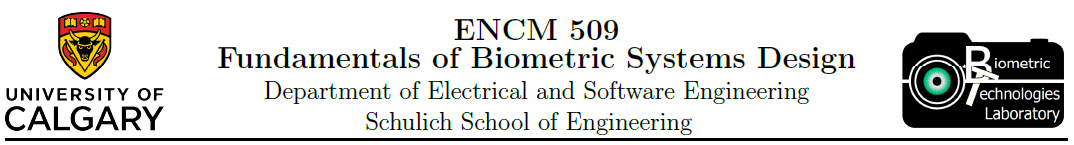

# ENCM 509 - Lab 3 Report

**Student Names**


**Mushtaba Al Yasseen (30094000)**
\
**Usman Khan (30092202)**

Importing all necessary libraries

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# **Introduction:**

The purpose of this lab is to understand biometric-based verification between genuine and imposter signatures for 1:1 matching. In the previous lab, we utilized values such as pressure, time, and coordinates, however, in this lab, we will separate the data into 2 simple classes and train the data based on the EM algorithm. After training the data, we will also utilize the Gaussian Mixture Model (GMM) to calculate log-likelihood scores in order to distinguish the classes of genuine and imposter signatures, essentially "verifying" if the signature is genuine or not. In addition, we will also use the log-likelihood score to calculate both the mean $(\mu)$ and standard deviation $(\sigma)$ of both the imposter and genuine scores in order to plot normal distributions, illustrating how they vary with one another. 

## **Exercise 1:**

Loading genuine "Labs" and imposter "Labs" signature data:

In [205]:
base_dir = './Data/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'Usman-Labs/'
dir_impostor = base_dir + 'Mushtaba-Labs/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

print('Size of the "auth_lst" vector: %d' % (len(auth_lst)))
print('Size of the "imp_lst" vector: %d' % (len(imp_lst)))

Size of the "auth_lst" vector: 30
Size of the "imp_lst" vector: 30


Creating and training the GMM model in order to plot normalized Probability Density Functions. The method below takes in 2 parameters, the number of signatures that will be used to train the GMM model, and the number of Gaussian mixture components. Later, we will plot 4 different sets of distributions for 4 different sets of parameters and compare their differences. In addition, we will find the mean $(\mu)$ and standard deviation $(\sigma)$ for both the genuine and imposter scores.

In [206]:
def GMM_distribution(auth_lst, imp_lst, num_of_signatures, num_of_gmm_components):

    # number of signature samples to use for training the models
    NUMTRAININGPATTERNS = num_of_signatures
    # number of Gaussian mixture components in the GMM
    NUMGCOMPONENTS = num_of_gmm_components

    # first, we will select the subset of signatures to train
    # usually we don't know the final size of train_set because
    # each signature has different number of points. 
    # to later on use 'concatenate', is necessary to take the first sample outside the loop
    train_set = np.reshape(auth_lst[0], (-1,4))

    # this for-loop put all the first "NUMTRAININGPATTERNS" in a huge matrix
    # this matrix, stored in the varaible "train_set" will be used for the training
    for i in range(1,NUMTRAININGPATTERNS):
        # taking from authentic/genuine
        sample = np.reshape(auth_lst[i], (-1,4))
        train_set = np.concatenate((train_set, sample), axis=0)

    # Training the GaussianMixture model from Scikit-Learn library
    # the .fit(...) will perform the training step using the "train_set" 
    gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)

    # using remaining genuine samples to calculate the log-likelihood score
    aScores = []

    # going through the remaining signatures after removing the first 20 for training
    for i in range(NUMTRAININGPATTERNS, total_signatures):
        # taking from authentic/genuine
        sample =  np.reshape(auth_lst[i], (-1,4))
        # compute the per-sample average log-likelihood of the given data.
        score = gmm.score(sample)
        # print('%d: %.4f' % (i, score))
        # add the score calculated to the list aScores
        aScores.append(score)

    # calculating the log-likelihood score score of the imposter samples to check how the GMM model
    # distinguishes the classes of genuine and imposter signatures
    fScores = []
    for i in range(numForgedSigs):
        # taking from the impostor
        sample =  np.reshape(imp_lst[i], (-1,4))
        score = gmm.score(sample)
        # print('%d: %.4f' % (i, score))
        fScores.append(score)

    # calculating the mean and standard deviation of the scores

    # genuine set
    aMu = np.mean(aScores)
    aStd = np.std(aScores)

    # impostor set
    fMu = np.mean(fScores)
    fStd = np.std(fScores)

    print('Mean of genuine scores: %.4f' % (aMu))
    print('Standard deviation of genuine scores: %.4f' % (aStd))
    print('Mean of imposter scores: %.4f' % (fMu))
    print('Standard deviation of imposter scores: %.4f' % (fStd))

    # change this range for your set
    x = np.arange(min(fScores) - 10, max(aScores) + 20, 0.01)

    aProb = norm.pdf(x, loc=aMu, scale=aStd)
    fProb = norm.pdf(x, loc=fMu, scale=fStd)
    plt.plot(x, aProb, 'g')
    plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
    plt.plot(x, fProb, 'r')
    plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

    plt.figure(figsize=(10,4))

    # Authentic set
    x = np.arange(min(aScores) - 10, max(aScores) + 20, 0.01)
    aProb = norm.pdf(x, loc=aMu, scale=aStd)

    plt.subplot(1,2,1)
    plt.plot(x, aProb, 'g')
    plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));


    # Forged (impostor) set
    x = np.arange(min(fScores) - 10, max(fScores) + 20, 0.01)
    fProb = norm.pdf(x, loc=fMu, scale=fStd)

    plt.subplot(1,2,2)
    plt.plot(x, fProb, 'r')
    plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
    plt.legend();
    plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

#### Set # 1 - 20 Training Signatures, 20 Gaussian Components

Mean of genuine scores: -19.3416
Standard deviation of genuine scores: 3.2562
Mean of imposter scores: -24.7430
Standard deviation of imposter scores: 1.9060


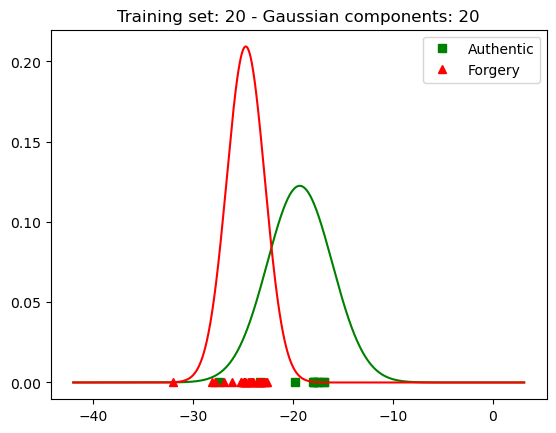

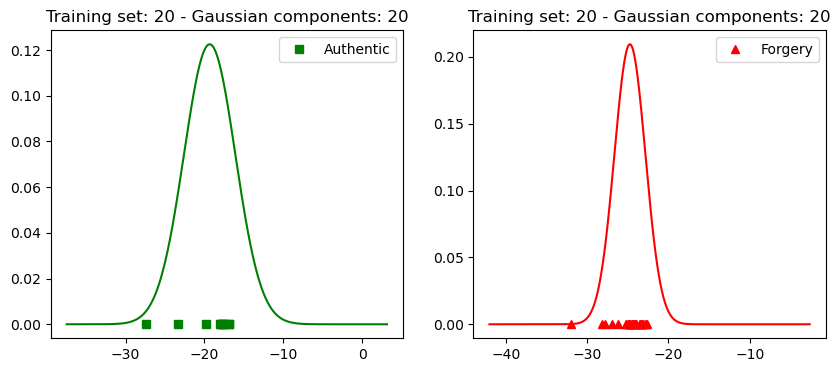

In [207]:
GMM_distribution(auth_lst, imp_lst, 20, 20)

#### Set # 2 - 10 Training Signatures, 20 Gaussian Components

Mean of genuine scores: -20.9308
Standard deviation of genuine scores: 4.5508
Mean of imposter scores: -34.4201
Standard deviation of imposter scores: 2.7632


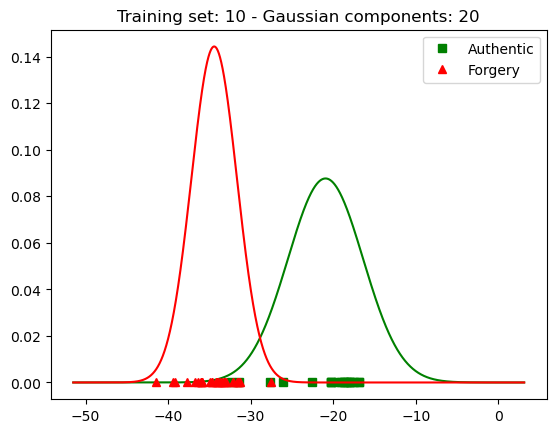

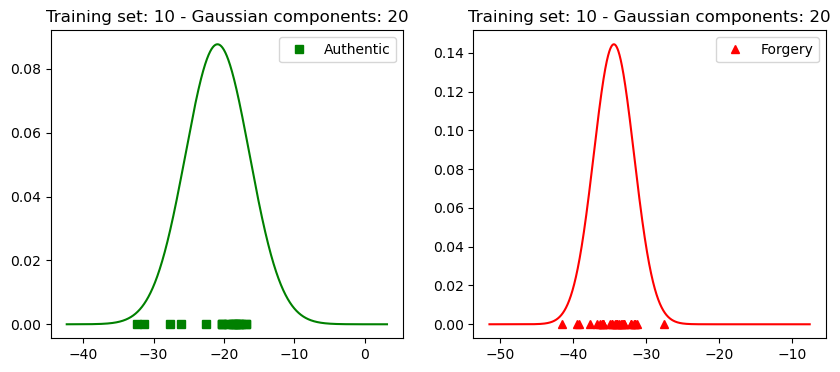

In [208]:
GMM_distribution(auth_lst, imp_lst, 10, 20)

#### Set # 3 - 10 Training Signatures, 40 Gaussian Components

Mean of genuine scores: -26.7186
Standard deviation of genuine scores: 10.5471
Mean of imposter scores: -51.0012
Standard deviation of imposter scores: 7.3433


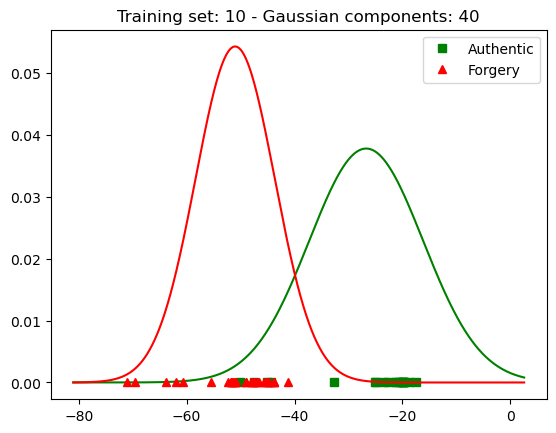

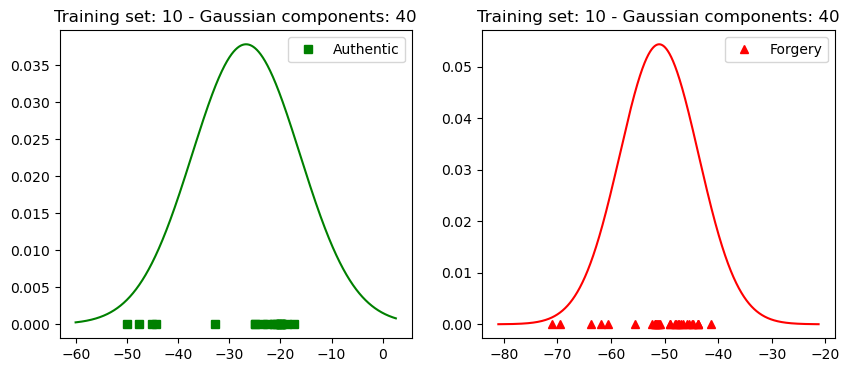

In [209]:
GMM_distribution(auth_lst, imp_lst, 10, 40)

#### Set # 4 - 20 Training Signatures, 40 Gaussian Components

Mean of genuine scores: -21.4781
Standard deviation of genuine scores: 6.6530
Mean of imposter scores: -34.9427
Standard deviation of imposter scores: 2.5578


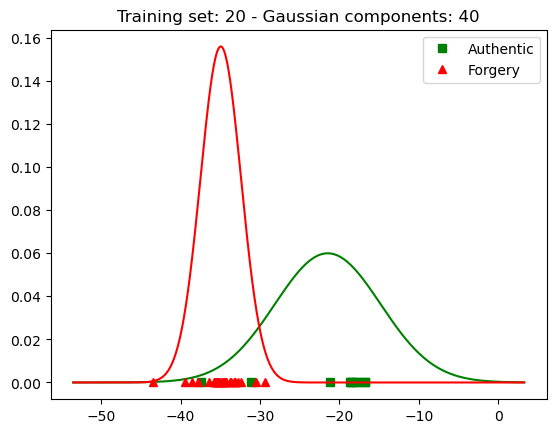

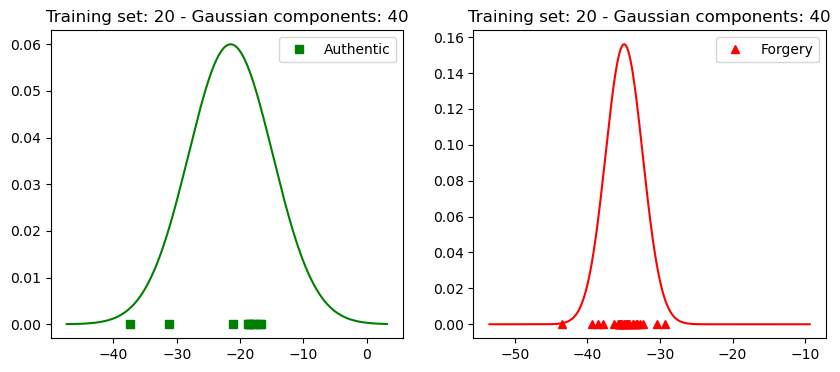

In [210]:
GMM_distribution(auth_lst, imp_lst, 20, 40)

#### Analysis Of Data:

Before analyzing the rest of the illustrations, we'll use the first illustration (20 signatures and 20 gaussian components) as the baseline for seeing how changing the parameters influences the classification results. First of all, for the base illustration (20, 20), we can see that both the genuine and imposter normal distributions have the most overlap, and thus, the highest FNMR. If we decrease the number of signatures to 10 (10, 20), the standard deviation of both the genuine and imposter signatures drops, which makes sense considering it is a smaller data set, while the mean for both increases, causing the normal distributions to move apart, making it easier to differentiate between the two signatures. Interestingly enough, if we keep the number of signatures to 10 but we increase the gaussian components to 40, the mean of the imposter scores increases significantly, which more accurately describes the distribution of the imposter scores. However, by increasing the number of signatures to 20 (20, 40), the standard deviation of both the imposter and genuine signatures starts to decrease once again, which makes sense, as with the larger data set, the outliers start to have less significance.

## **Exercise 2:**

Loading genuine "Labs" and imposter "Word" signature data:

In [211]:
base_dir = './Data/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'Usman-Labs/'
dir_impostor = base_dir + 'Mushtaba-Word/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

print('Size of the "auth_lst" vector: %d' % (len(auth_lst)))
print('Size of the "imp_lst" vector: %d' % (len(imp_lst)))

Size of the "auth_lst" vector: 30
Size of the "imp_lst" vector: 30


#### Set # 1 - 20 Training Signatures, 20 Gaussian Components

Mean of genuine scores: -19.8643
Standard deviation of genuine scores: 4.1807
Mean of imposter scores: -30.7798
Standard deviation of imposter scores: 1.1085


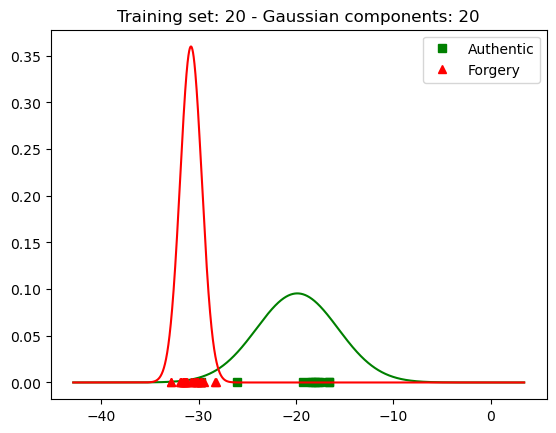

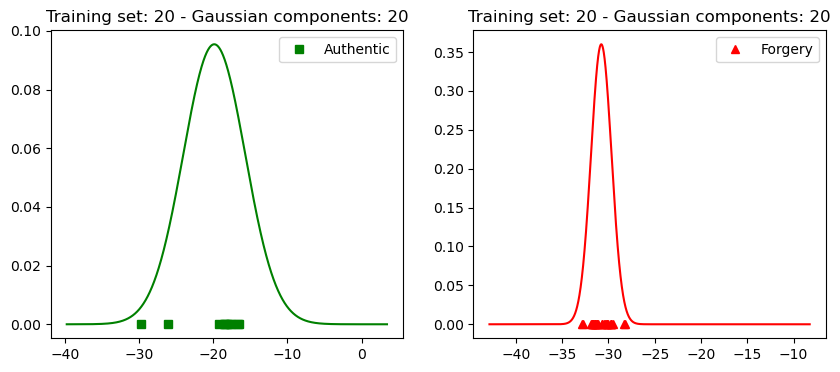

In [212]:
GMM_distribution(auth_lst, imp_lst, 20, 20)

#### Set # 2 - 10 Training Signatures, 20 Gaussian Components

Mean of genuine scores: -21.1321
Standard deviation of genuine scores: 4.7531
Mean of imposter scores: -33.5864
Standard deviation of imposter scores: 1.6969


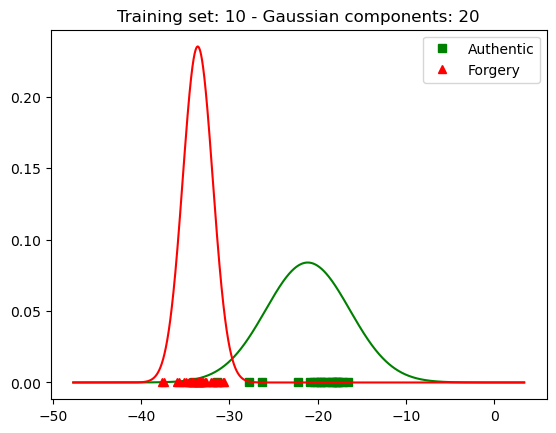

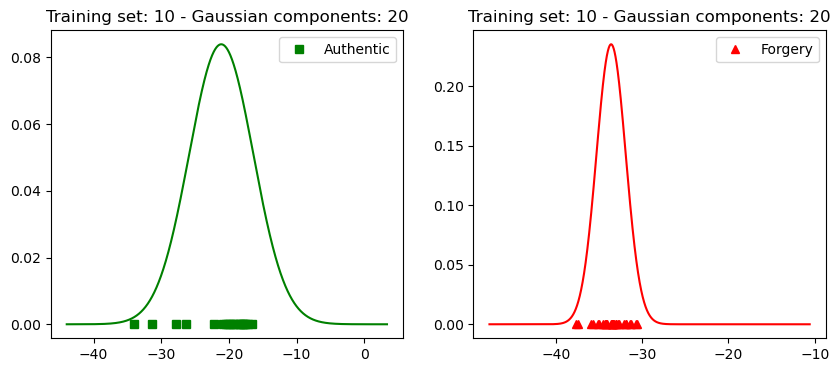

In [213]:
GMM_distribution(auth_lst, imp_lst, 10, 20)

#### Set # 3 - 10 Training Signatures, 40 Gaussian Components

Mean of genuine scores: -22.2563
Standard deviation of genuine scores: 4.7212
Mean of imposter scores: -35.3525
Standard deviation of imposter scores: 1.4184


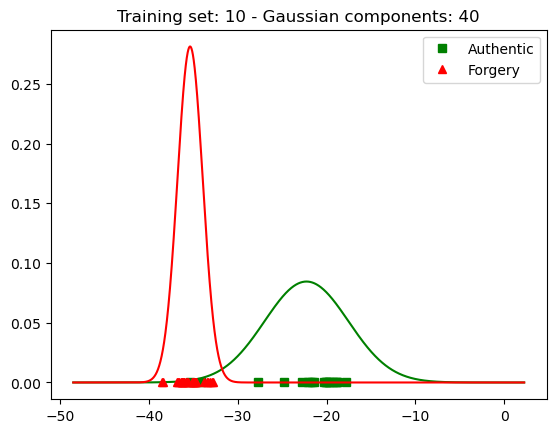

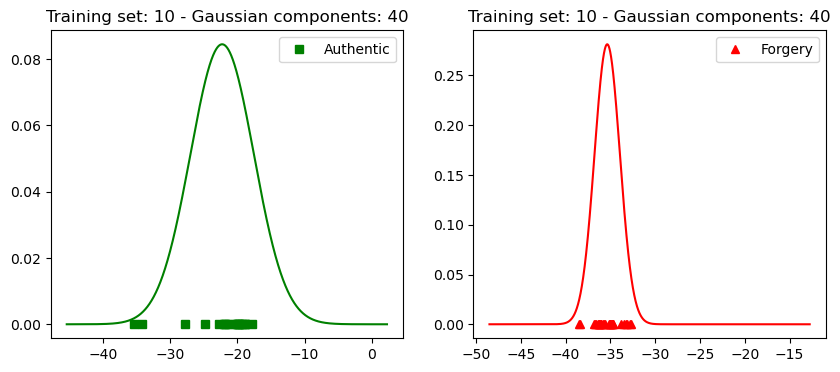

In [214]:
GMM_distribution(auth_lst, imp_lst, 10, 40)

#### Set # 4 - 20 Training Signatures, 40 Gaussian Components

Mean of genuine scores: -24.0747
Standard deviation of genuine scores: 11.9243
Mean of imposter scores: -66.8210
Standard deviation of imposter scores: 5.9405


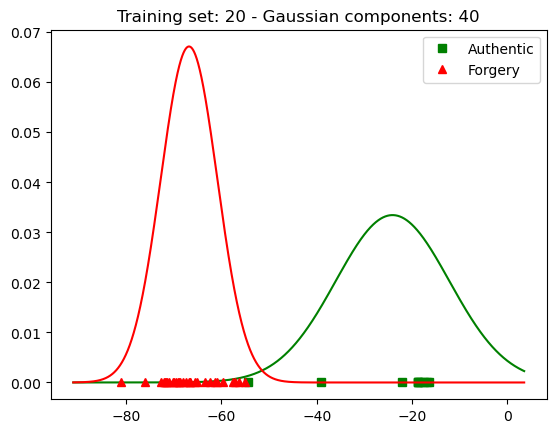

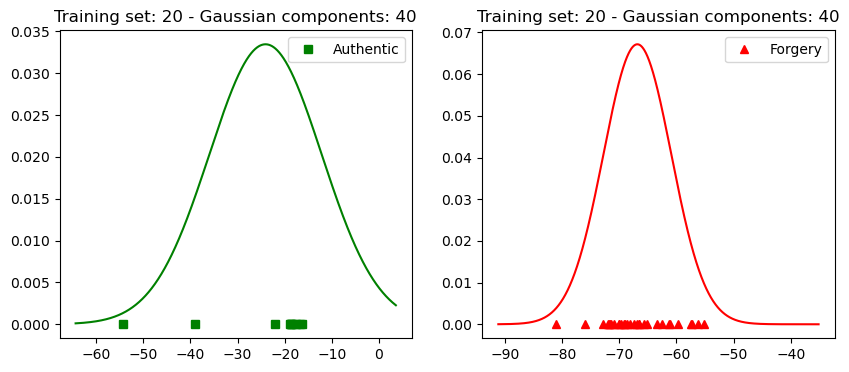

In [215]:
GMM_distribution(auth_lst, imp_lst, 20, 40)

#### Analysis Of Data:

The mixtures for the GMM distributions were kept consistent for better analysis (20, 20), (10, 20), (20, 40), (10, 40):

First of all, for the base illustration (20, 20), we can see that When compared with the graphs form exercise 1, there appears to be a clear divergence, as the graphs from exercise 2 have less overlap between the authentic and forgery samples. This makes sense, as we are comparing completely different words as oppposed to exercise 1 and points to a greater accuracy of the model. The area of false match rate seems to be reduced. If we decrease the number of signatures to 10 (10, 20), the FNMR now starts to increase due to smaller data set, increasing the absolute mean and standard deviation of the imposter scores. Interestingly enough, by increasing the gaussian components, the FNMR starts to increase with 10 signatures. Overall, exercise 2 showed a much larger discrepancy between the genuine and imposter scores compared to exercise 1.

## **Exercise 3:**


Note: the values for Mean and STD change with every run of the cells

Using set 4 from exercise 1:

![image](Chapter3.png)

# **Conclusion:**


In conclusion, this lab's exploration into biometric-based verification through 1:1 matching of genuine and imposter signatures provided profound insights into the dynamics of classification accuracy. Leveraging the Expectation-Maximization algorithm for data training and employing the Gaussian Mixture Model (GMM) for log-likelihood computations, the lab highlighted the delicate interplay between data parameters and their impact on model performance. Initial findings from Exercise 1, utilizing varying signature counts and Gaussian components, revealed the influence of dataset size and distribution complexities on the overlap between genuine and imposter distributions and the False Non-Match Rate (FNMR). Extending this analysis, Exercise 2 maintained consistent mixtures for the GMM distributions, unveiling a marked divergence from Exercise 1's outcomes. Notably, the reduction in overlap between authentic and forgery samples in the base case (20, 20) indicated an enhancement in model accuracy. However, variations in signature counts and Gaussian components nuanced our understanding of the model's sensitivity, especially the increased FNMR with reduced data size or adjusted Gaussian components. This comprehensive examination underscores the nuanced balance required in model parameters, ultimately enriching our understanding of biometric verification's complexities and paving the way for more accurate and reliable authentication systems.